In [15]:
import sys, os, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# --- local package ------------------------------------------------------------
sys.path.append(os.path.abspath('..'))
from mlmc import MLMC,  C_MLMC, WeakConvergenceError
from mlmc.bs_level_path_dependant import MilsteinBSLevelFunction
from mlmc.payoffs import digital_payoff

In [16]:
# parameters
S0, K = 95.0, 100.0
r, sigma  = 0.05, 0.1
T     = 1.0

# Target tolerances for demonstration
EPS = [0.2, 0.1, 0.05, 0.025,0.025/2]


In [17]:
def asian_call_reference_price(S0=100, K=100, r=0.05, sigma=0.1, T=1.0, N=1_000_000, M=1024, seed=42):
    rng = np.random.default_rng(seed)
    h = T / M
    dt_sqrt = np.sqrt(h)

    S = np.full((N, M + 1), S0)
    for i in range(M):
        Z = rng.normal(0, 1, N)
        S[:, i + 1] = S[:, i] * np.exp((r - 0.5 * sigma**2) * h + sigma * dt_sqrt * Z)

    S_avg = S.mean(axis=1)

    payoff = np.maximum(S_avg - K, 0)

    price = np.exp(-r * T) * payoff.mean()
    print(f"[Reference MC] Asian call price ≈ {price:.6f}")
    return price
ref_price = asian_call_reference_price(S0=S0, K=K, r=r, sigma=sigma, T=T, N=100000, M=1000, seed=42)


[Reference MC] Asian call price ≈ 1.176119


# MLMC

In [18]:
# MLMC setup
def asian_call(S_T, path, K=100):
    avg = path.mean(axis=1) if path.ndim == 2 else path.mean()
    return np.maximum(avg - K, 0)

payoff_fn = lambda S_T, path: asian_call(S_T, path, K=100)

level_fn = MilsteinBSLevelFunction(S0, K, r, sigma, T, payoff_fn).simulate

mlmc_obj = MLMC(level_fn, Lmin=2, Lmax=20, N0=500)

In [19]:
# Run standard MLMC 
records = []

for eps in EPS:
    rec = {"epsilon": eps}
    try:
        t0 = time.perf_counter()
        price, Nl, Cl, total_cost = mlmc_obj.estimate(eps)
        t1 = time.perf_counter()

        rec.update({
            "price": price,
            "time_s": t1 - t0,
            "total_cost": total_cost,
            "N_per_level": Nl.copy(),
        })

    except WeakConvergenceError as err:
        rec.update({
            "price": np.nan,
            "time_s": np.nan,
            "total_cost": np.nan,
            "N_per_level": None,
            "error": str(err),
        })

    records.append(rec)


[Bias Check] L=2, extrapolated remainder=3.1917e+00, threshold=1.0000e-01
[Bias Check] L=3, extrapolated remainder=5.0610e-01, threshold=1.0000e-01
[Bias Check] L=4, extrapolated remainder=2.6613e-01, threshold=1.0000e-01
[Bias Check] L=5, extrapolated remainder=2.0883e-01, threshold=1.0000e-01
[Bias Check] L=6, extrapolated remainder=1.3173e-01, threshold=1.0000e-01
[Bias Check] L=7, extrapolated remainder=6.4654e-02, threshold=1.0000e-01
[Bias Check] L=2, extrapolated remainder=4.4762e+00, threshold=5.0000e-02
[Bias Check] L=3, extrapolated remainder=5.6592e-01, threshold=5.0000e-02
[Bias Check] L=4, extrapolated remainder=4.7793e-01, threshold=5.0000e-02
[Bias Check] L=5, extrapolated remainder=2.0310e-01, threshold=5.0000e-02
[Bias Check] L=6, extrapolated remainder=5.5190e-02, threshold=5.0000e-02
[Bias Check] L=7, extrapolated remainder=6.9511e-02, threshold=5.0000e-02
[Bias Check] L=8, extrapolated remainder=3.2981e-02, threshold=5.0000e-02
[Bias Check] L=2, extrapolated remaind

In [20]:
# exact price
print(f"Exact price: {ref_price}")

# results
df = pd.DataFrame(records)

Nl_df = pd.DataFrame(df["N_per_level"].tolist(), index=df.index).add_prefix("N_l_")
out = pd.concat([df.drop(columns="N_per_level"), Nl_df], axis=1)
out = out.fillna(0)
display(out)


Exact price: 1.1761186577987286


,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2,N_l_3,N_l_4,N_l_5,N_l_6,N_l_7,N_l_8,N_l_9,N_l_10,N_l_11
0,0.2000,1.081730,0.005095,127500.0,500,500,500,500,500,500,500,500,0.0,0.0,0.0,0.0
1,0.1000,1.243653,0.007096,257132.0,2014,559,500,500,500,500,500,500,500.0,0.0,0.0,0.0
2,0.0500,1.241116,0.014941,525107.0,7957,2357,1091,509,500,500,500,500,500.0,500.0,0.0,0.0
3,0.0250,1.154606,0.030058,1105810.0,32350,9750,4670,1924,743,500,500,500,500.0,500.0,500.0,0.0
4,0.0125,1.163215,0.060402,2446974.0,130588,38873,18114,7765,3128,1188,500,500,500.0,500.0,500.0,500.0


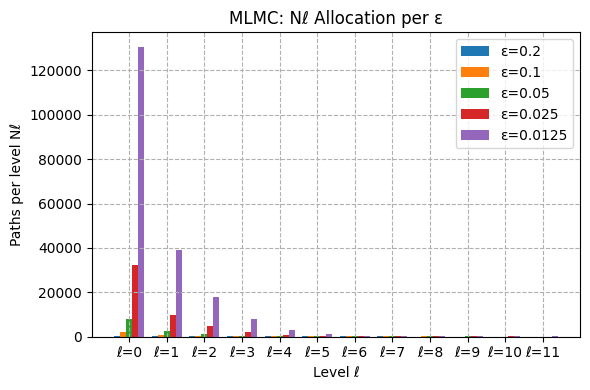

In [21]:
level_cols = [col for col in out.columns if col.startswith("N_l_")]
levels = np.arange(len(level_cols))
bar_width = 0.8 / len(out)

fig, ax = plt.subplots(figsize=(6, 4))

for i, (_, row) in enumerate(out.iterrows()):
    Nl = row[level_cols].values
    ax.bar(levels + i * bar_width, Nl, width=bar_width, label=f"ε={row['epsilon']}")

ax.set_xticks(levels + bar_width * (len(out) - 1) / 2)
ax.set_xticklabels([col.replace("N_l_", "ℓ=") for col in level_cols])
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nℓ")
ax.set_title("MLMC: Nℓ Allocation per ε")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [22]:
# Inspect Yₗ for levels 0 and 1 to compare payoff variance vs. increment variance
N_test = 100_000

for l_test in [0, 1, 2, 3, 4 ,5]:
    # simulate N_test coupled samples at level l_test
    sums, cost = mlmc_obj._f(l_test, N_test)
    sumY, sumY2 = sums

    # empirical mean and variance of Yₗ
    meanY = sumY  / N_test
    varY  = sumY2 / N_test - meanY**2

    print(f"Level {l_test}: mean(Y_{l_test}) = {meanY:.3e}, var(Y_{l_test}) = {varY:.3e}")


Level 0: mean(Y_0) = 8.698e-01, var(Y_0) = 3.912e+00
Level 1: mean(Y_1) = 1.112e-01, var(Y_1) = 6.968e-01
Level 2: mean(Y_2) = 8.180e-02, var(Y_2) = 3.090e-01
Level 3: mean(Y_3) = 5.421e-02, var(Y_3) = 1.103e-01
Level 4: mean(Y_4) = 2.962e-02, var(Y_4) = 3.369e-02
Level 5: mean(Y_5) = 1.585e-02, var(Y_5) = 9.303e-03


# C-MLMC

In [23]:
# feature extractor for C_MLMC
def feature_fn(detail):
    f_avg = detail["avg_fine"]
    f_min = detail["min_fine"]
    f_last = detail["S_fine"]  # final value is here

    if "avg_coarse" in detail:
        c_avg = detail["avg_coarse"]
        c_min = detail["min_coarse"]
        c_last = detail["S_coarse"]

        return np.array([
            f_avg,             # payoff driver
            f_avg - c_avg,     # control variate discrepancy
            f_min - c_min,     # path shape discrepancy
            f_last - c_last    # terminal deviation
        ])
    else:
        return np.array([
            f_avg,
            f_min,
            f_last
        ])


cmlmc_obj  = C_MLMC(level_fn, feature_fn, Lmin=2, Lmax=20, n_clusters=3, N0=500, scale_features=True)


In [24]:
# Run C-MLMC
records2 = []

for eps in EPS:
    rec = {"epsilon": eps}
    try:
        t0 = time.perf_counter()
        price, Nl, Cl, total_cost = cmlmc_obj.estimate(eps)
        t1 = time.perf_counter()

        rec.update({
            "price": price,
            "time_s": t1 - t0,
            "total_cost": total_cost,
            "N_per_level": Nl.copy(),
        })

    except WeakConvergenceError as err:
        rec.update({
            "price": np.nan,
            "time_s": np.nan,
            "total_cost": np.nan,
            "N_per_level": None,
            "error": str(err),
        })

    records2.append(rec)

In [25]:
# exact price
print(f"Exact price: {ref_price}")

# results
df2 = pd.DataFrame(records2)

Nl_df2 = pd.DataFrame(df2["N_per_level"].tolist(), index=df2.index).add_prefix("N_l_")
out2 = pd.concat([df2.drop(columns="N_per_level"), Nl_df2], axis=1)
out2 = out2.fillna(0)
display(out2)

Exact price: 1.1761186577987286


,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2,N_l_3,N_l_4,N_l_5,N_l_6,N_l_7,N_l_8,N_l_9,N_l_10,N_l_11,N_l_12
0,0.2000,1.027407,0.037887,127500.0,500,500,500,500,500,500,500,500,0.0,0.0,0.0,0.0,0.0
1,0.1000,1.184635,0.152599,288336.0,3336,523,500,500,500,500,500,500,500.0,0.0,0.0,0.0,0.0
2,0.0500,1.159819,0.408162,664801.0,17801,1378,683,791,500,500,500,500,500.0,500.0,0.0,0.0,0.0
3,0.0250,1.333833,1.359145,1225111.0,78111,6534,2131,3855,2024,792,500,500,500.0,500.0,0.0,0.0,0.0
4,0.0125,1.358785,3.580167,6209221.0,270221,32355,11223,14593,6247,2453,964,500,500.0,500.0,500.0,500.0,500.0


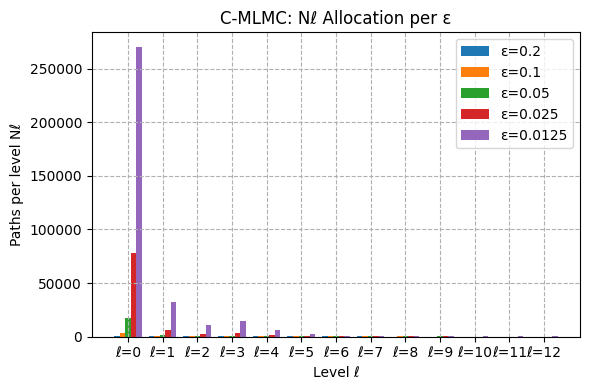

In [26]:
level_cols = [col for col in out2.columns if col.startswith("N_l_")]
levels = np.arange(len(level_cols))
bar_width = 0.8 / len(out2)

fig, ax = plt.subplots(figsize=(6, 4))

for i, (_, row) in enumerate(out2.iterrows()):
    Nl = row[level_cols].values
    ax.bar(levels + i * bar_width, Nl, width=bar_width, label=f"ε={row['epsilon']}")

ax.set_xticks(levels + bar_width * (len(out2) - 1) / 2)
ax.set_xticklabels([col.replace("N_l_", "ℓ=") for col in level_cols])
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nℓ")
ax.set_title("C-MLMC: Nℓ Allocation per ε")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

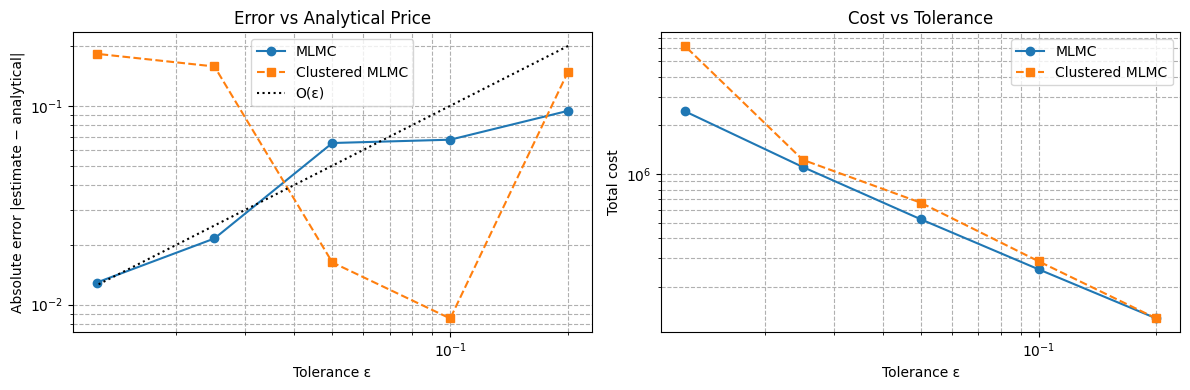

In [27]:
tols      = out["epsilon"].values
errors_ml = abs(out["price"] - ref_price)
errors_cl = abs(out2["price"] - ref_price)
costs_ml  = out["total_cost"].values
costs_cl  = out2["total_cost"].values

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Error vs Analytical
axs[0].loglog(tols, errors_ml, 'o-', label='MLMC')
axs[0].loglog(tols, errors_cl, 's--', label='Clustered MLMC')
axs[0].loglog(tols, tols, 'k:', label='O(ε)')
axs[0].set_xlabel("Tolerance ε")
axs[0].set_ylabel("Absolute error |estimate − analytical|")
axs[0].set_title("Error vs Analytical Price")
axs[0].legend()
axs[0].grid(True, which="both", ls="--")

# Cost vs Tolerance
axs[1].loglog(tols, costs_ml, 'o-', label='MLMC')
axs[1].loglog(tols, costs_cl, 's--', label='Clustered MLMC')
axs[1].set_xlabel("Tolerance ε")
axs[1].set_ylabel("Total cost")
axs[1].set_title("Cost vs Tolerance")
axs[1].legend()
axs[1].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

In [28]:
info = cmlmc_obj.get_cluster_info(level=1)
print("Cluster centers:\n", info["centers"])
print("Cluster probabilities:\n", info["probs"])
print("Cluster variances:\n", info["vars"])

Cluster centers:
 [[ 0.96884803  0.36483235  0.44825801  0.87598709]
 [-0.683213    0.03992214  0.21377277 -0.71880727]
 [-0.60275598 -1.47310859 -2.50063731 -0.12116543]]
Cluster probabilities:
 [0.408 0.478 0.114]
Cluster variances:
 [1.29302938e+00 1.00000000e-06 3.55156923e-01]
